## Parallel Quanvolution - NVidia, JAX, AWS 

### Question

QML algorithms usually initialize multiple calls to Quantum Circuits.

For particular algorithms - such calls can be parallelized.

Let's take famous Quanvolution - clearly explained in below Pennylane tutorial:

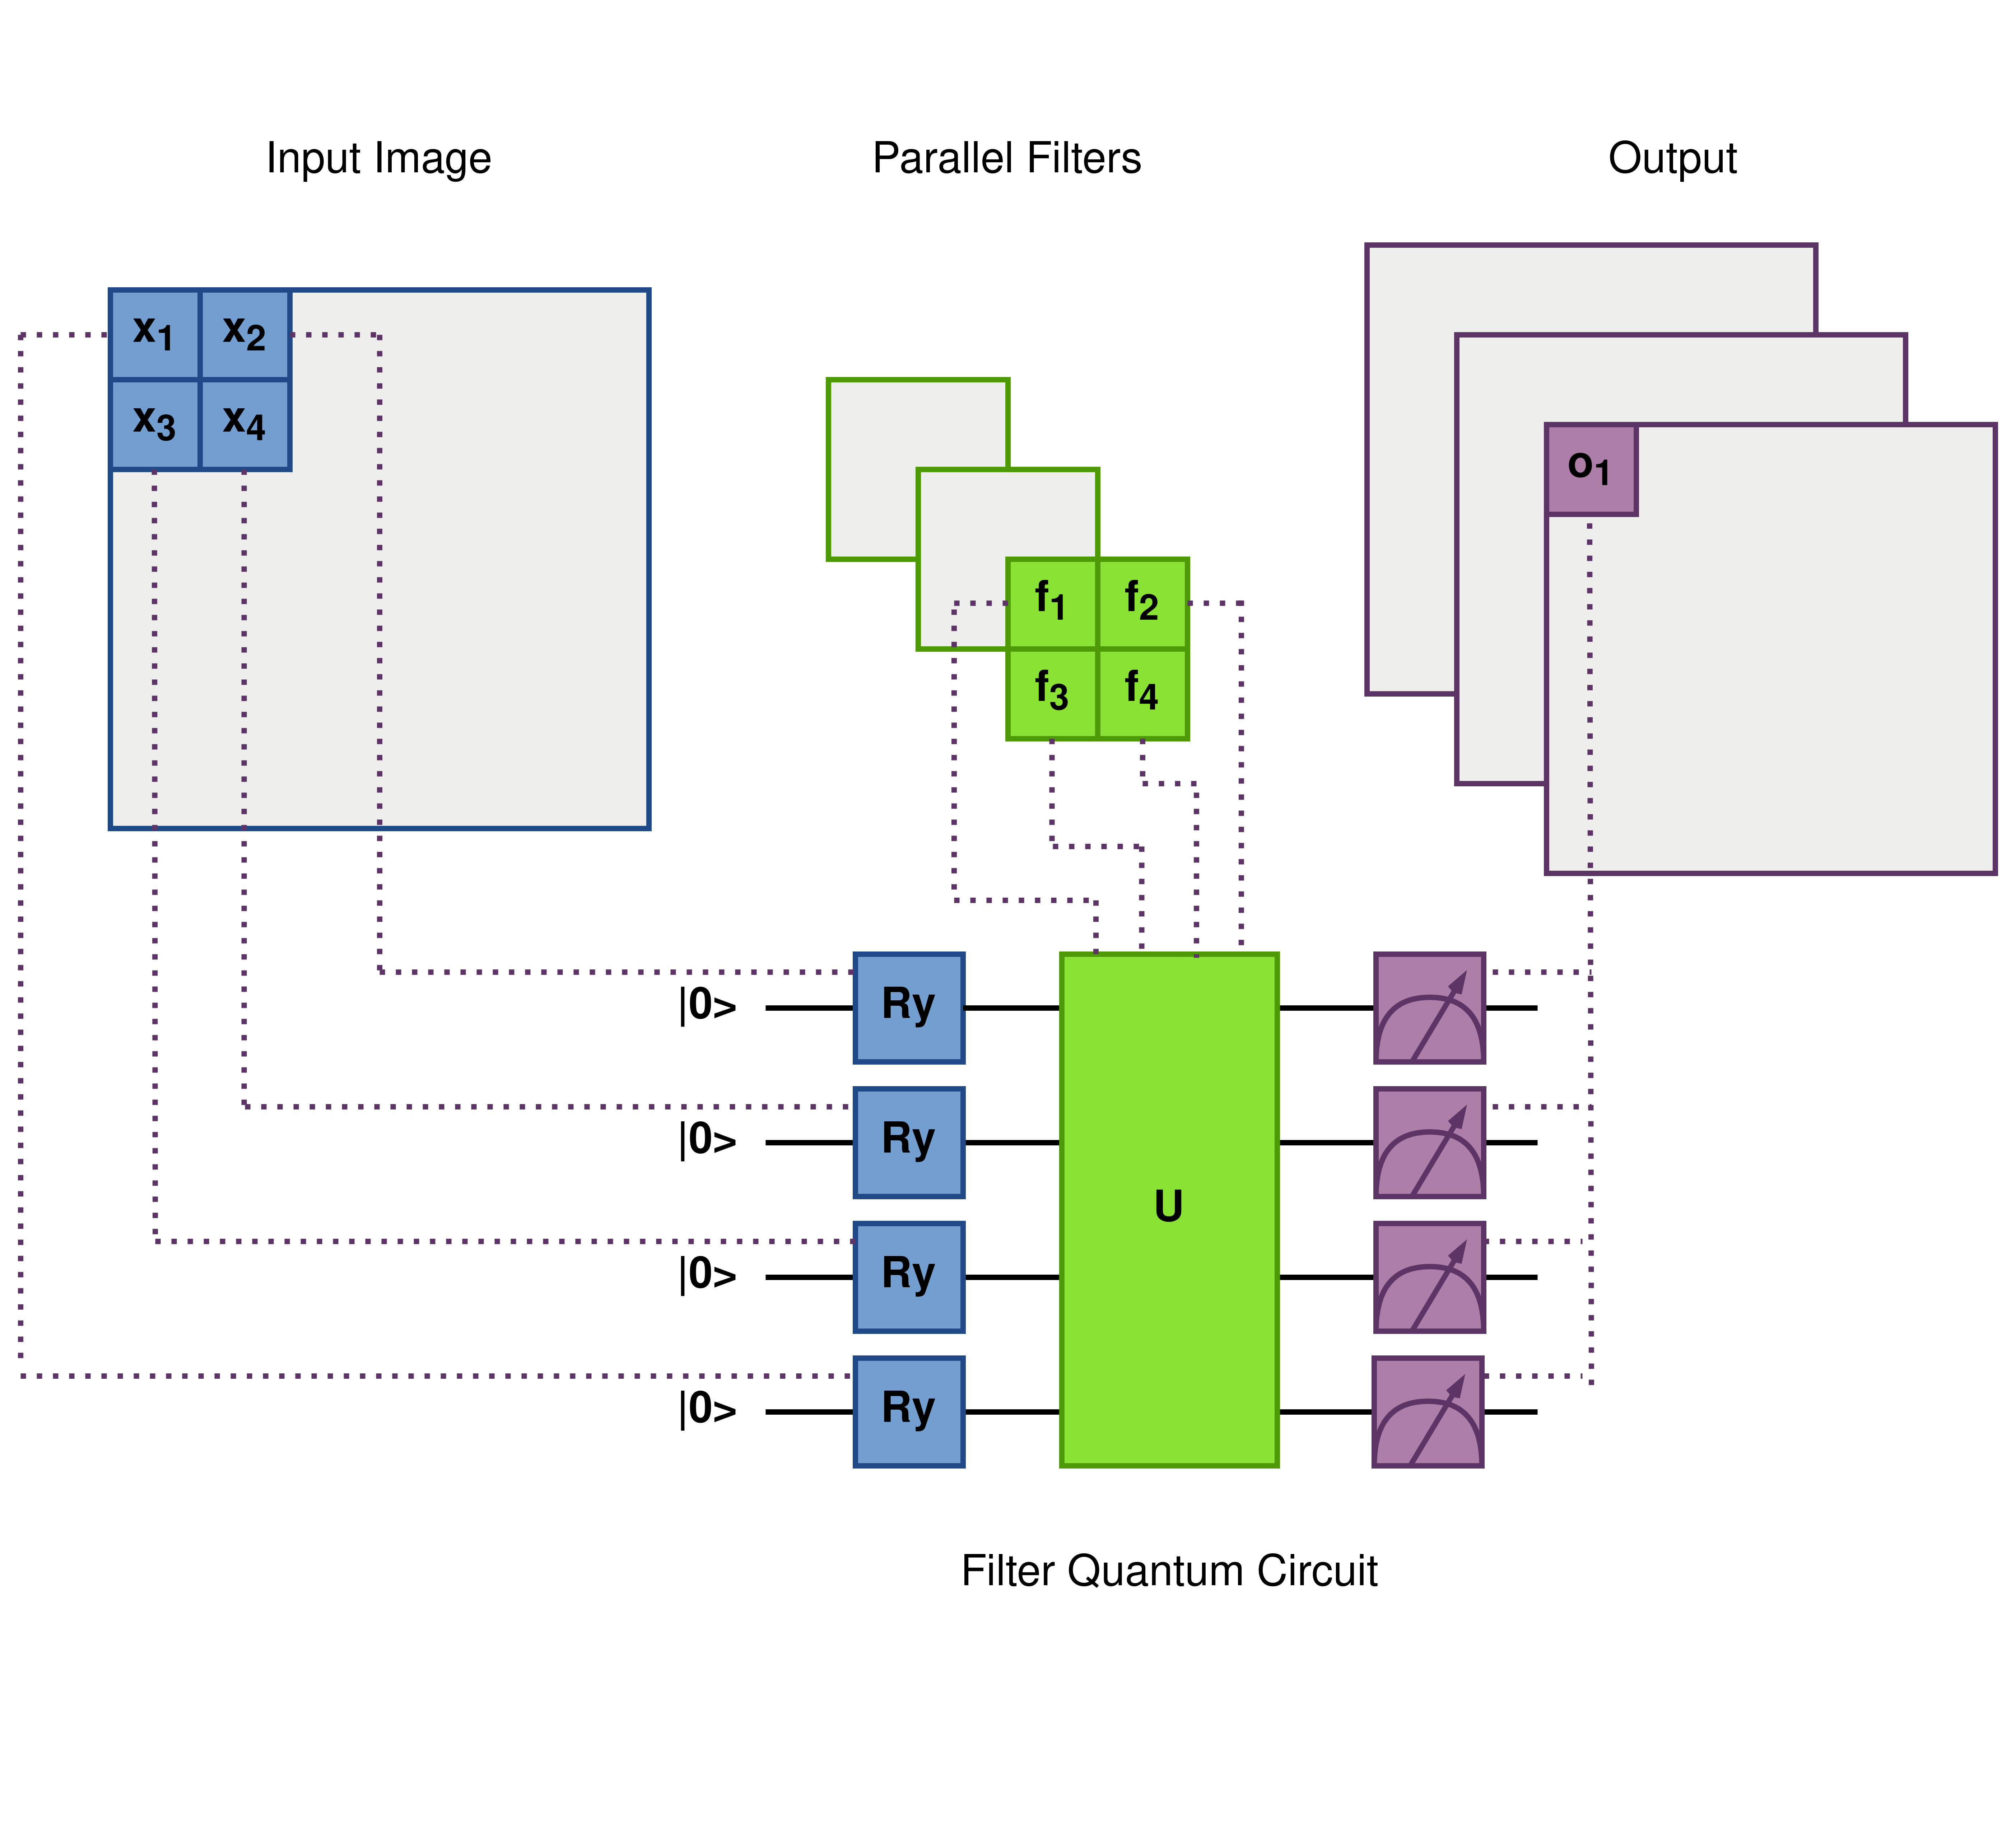

https://pennylane.ai/qml/demos/tutorial_quanvolution.html

As we can see - Filter Quantum Circuits can be applied to input image 100s and 1000s of times during one forward pass.

So we have asked ourseves - **how can we run Quanvolution in parallel?)**

### Solutions

We decided to try 3 approaches:

1) NVidia PennyLane Lightning GPU
2) Parallel execution with JAX
3) Parallel execution with JAX and AWS SV1 managed Simulator

And used below backends:


* `default.qubit` - basic simulator

* `lightning.qubit` - C++ fast simulator

* `lightning.gpu` - GPU-accelerated simulator using NVidia cuQuantum SDK

* `lightning.gpu` - Multi-GPU setup with `batch_obs=True`

* `default.qubit.jax` - for JAX parallelization

* `braket.local.qubit` - AWS local simulator

* `braket.aws.qubit` - to call AWS managed Simulators in parallel)

Service functions are at [`functions.ipynb`](functions.ipynb) notebook - with below sections:

* Parameters Processing
* Image Processing
* Quantum
* Parallelization
* Experiments
* Visualization

Full functions description is at Code Explanation section below.

### Approach 1 - NVidia

NVidia servers can be used as great instruments for Quantum simulations.

Therefore - we first decided to utilize power of PennyLane Lightning GPU including multi-GPU execution:

https://pennylane.ai/blog/2022/07/lightning-fast-simulations-with-pennylane-and-the-nvidia-cuquantum-sdk/

In order to utilize `PennLane Lightning GPU` - following stack of Quantum Simulators was launched in Docker Container on remote DGX:

```
Quantum Machine Learning: PennyLane
Quantum Error Mitigation: Qermit, Mitiq
Quantum Frameworks:       Qiskit, Pytket, Cirq, QSim, AWS Braket
ML and Scientific:        PyTorch, TensorFlow, JAX
Remote Access:            Jupyter Enterprise Gateway
NVidia Specific:          cuQuantumSDK, CUDA Toolkit
Based Container:          Docker cuQuantum Appliance
Platform:                 DGX-2, DGX A100
```

Local `Jupyter Notebook` is reaching remote iPython kernel of `Jupyter Enterprise Gateway` in container on DGX via SSH tunnel - so code is easily operated locally, while all computations are made on performant DGX)

#### Imports

In [31]:
import pennylane as qml

from pennylane import numpy as np
from pennylane.templates import RandomLayers

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt

import os
import time

from itertools import product
from itertools import combinations_with_replacement

from collections import defaultdict

from pennylane import numpy as jnp

%run functions.ipynb

TRACK_AWS_BRAKET_COST = False

#### Basic Example

To demonstrate Parallel Quanvolution - let's start with one MNIST image:




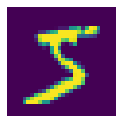

In [2]:
image = load_one_MNIST_image()

plot_image(image)

First - we run fast `lightning.qubit` with 2x2 filter: 

In [3]:
parameters = create_parameters(qml_device_types=["lightning.qubit"],
                               image_width=28,
                               image_height=28,
                               min_filter_width=2,
                               min_filter_height=2)

Parameters for our experiment are created by `create_parameters` function - which calculated filter applications and strides.

Now we can call `prepare_experiments` to generate all possible combinations:

In [4]:
experiments = prepare_experiments(parameters)

Experiments count: 1


In [5]:
run_experiments(experiments)

Experiment: 1/1
Device: lightning.qubit
Qubits per filter: 4
Filter repetitions: 729
Filter applications: 729
Execution time: 1.40 seconds



Execution time is written to `experiments` - so we can further process and plot it.

Once experiments are executed - they will not be run again:

In [6]:
run_experiments(experiments)

#### Variable Filter size

Next step would be to change Filter Circuit size - and corresponding number of qubits.

As Filter size grows - we need less Filter applications to quanvolve the same image: 

In [7]:
parameters = create_parameters(qml_device_types=["lightning.qubit"],
                               image_width=28,
                               image_height=28,
                               min_filter_width=16,
                               max_filter_width=18,
                               min_filter_height=1)

In [8]:
experiments = prepare_experiments(parameters)

run_experiments(experiments)

Experiments count: 3
Experiment: 1/3
Device: lightning.qubit
Qubits per filter: 16
Filter repetitions: 364
Filter applications: 364
Execution time: 2.80 seconds

Experiment: 2/3
Device: lightning.qubit
Qubits per filter: 17
Filter repetitions: 336
Filter applications: 336
Execution time: 4.06 seconds

Experiment: 3/3
Device: lightning.qubit
Qubits per filter: 18
Filter repetitions: 308
Filter applications: 308
Execution time: 8.14 seconds



We can also easily save and load experiments as numpy files:

In [9]:
np.save('experiments/new_experiments.npy', experiments)

In [10]:
experiments = np.load('experiments/new_experiments.npy', allow_pickle=True).item()

Since general framework is established - we can easily use below devices to run Quanvolution: 

In [ ]:
QML_DEVICE_TYPES = [
    "default.qubit",
    "lightning.qubit",
    "lightning.gpu",
    "lightning.gpu - multi-GPU",
]

Pennylane Lightning GPU device has newly introduced `batch_ops=True` mode - that allows to split large circuit calculations via multiple GPUs:

https://docs.pennylane.ai/projects/lightning-gpu/en/latest/devices.html

We have reproduced such setup in `lightning.gpu - multi-GPU` device type.

#### Multiple Filters

Quanvolution uses multiple filters - each having distinct set of trained weights.

Let's reproduce such setup with 8 filters:

In [12]:
parameters = create_parameters(qml_device_types=["lightning.qubit"],
                               image_width=28,
                               image_height=28,
                               min_filter_width=10,                               
                               min_filter_height=1,
                               min_filters_count=8,
                               max_filters_count=8)

In [13]:
experiments = prepare_experiments(parameters)

run_experiments(experiments)

Experiments count: 1
Experiment: 1/1
Device: lightning.qubit
Qubits per filter: 10
Filter repetitions: 532
Filter applications: 4256
Execution time: 13.20 seconds



We see that quanvolving 10-qubit filter over 28*28 image with stride 1 - requires 532 repetitions per 1 filter - and 4256 total applications for 8 filters.

At this point we would like to propose to add JAX and see what we can do further.

### Approach 2 - JAX

JAX is powerful scientific computing library - and below tutorial gives great explanation of basic usage with PennyLane:

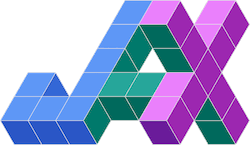

https://pennylane.ai/qml/demos/tutorial_jax_transformations.html

We'll use following features:

* Vectorization (VMap)
* Parallelization (PMap)
* Just-in-time compilation (JIT)



In [15]:
import jax
import jax.numpy as jnp

from jax.config import config

config.update("jax_enable_x64", True)    # to use double-precision numbers

We can use below environment variables to select real GPU CUDA Devices: 

In [16]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ", ".join(map(str, range(0, 16)))

Or we can emulate JAX Devices on CPU:

In [18]:
JAX_EMULATED_DEVICES_COUNT = 8

XLA_FLAGS = f"--xla_force_host_platform_device_count={JAX_EMULATED_DEVICES_COUNT}"

os.environ['XLA_FLAGS'] = XLA_FLAGS

jax.devices()

[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5),
 CpuDevice(id=6),
 CpuDevice(id=7)]

Let us run Quanvolution with 8 filters using JAX-compatible device - `default.qubit.jax`:

In [19]:
parameters = create_parameters(qml_device_types=["default.qubit.jax"],
                               image_width=28,
                               image_height=28,
                               min_filter_width=10,                               
                               min_filter_height=1,
                               min_filters_count=8,
                               max_filters_count=8)
                               
experiments = prepare_experiments(parameters)

run_experiments(experiments) 

Experiments count: 1
Experiment: 1/1
Device: default.qubit.jax
Qubits per filter: 10
Filter repetitions: 532
Filter applications: 4256
Execution time: 1.56 seconds



As we can see - execution time is 10 times faster compared to `lightning.qubit` device in previous section.

Speedup is obtained due to 3 JAX features:

<br>

**1) Vectorization (VMap)**

532 applications of 10-qubit filter are efficiently packed on 1 real or emulated GPU to be executed faster.

https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html 

<br>

**2) Parallelization (PMap)**

Setup contains 8 different filters with different trained weights - each filter is calculated on distinct real or emulated GPU - parallelizing calcualtion.

https://jax.readthedocs.io/en/latest/_autosummary/jax.pmap.html

<br>

**3) Just-in-time compilation (JIT)**

Optimizes code during runtime, uses cache to avoid repetitive calculations.

https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html

<br>

We put all code for VMap and PMap applications into [`Parallelization`](functions.ipynb#parallelization) section of [`functions.ipynb`](functions.ipynb) notebook.

Additional benefit brought by JIT is cashing - no consequent calls are made to Simulator for the same set of input parameters.

For example - it is typical to have large areas of 0-valued (black) pixels in the image.
Once Filter Circuit is applied for such set of pixels - no consequent calls to simulator is made - results are recovered from cache.

### Comparison

At this point we would like to present a comparison for mentioned PennyLane simulators.

We ran full set of experiments on NVidia DGX-2 and DGX A100 machines - and collected results.

What are the fastest devices for Quanvolution?)

#### 1 Filter

In [21]:
plt.style.use('default')

experiments = np.load('experiments/a100_jax_experiments_1_filter.npy', 
                      allow_pickle=True).item()

execution_times = aggregate_execution_times(experiments)

Execution times are marked on Linear and Logarithmic scales depending on Filter Circuit qubit counts:

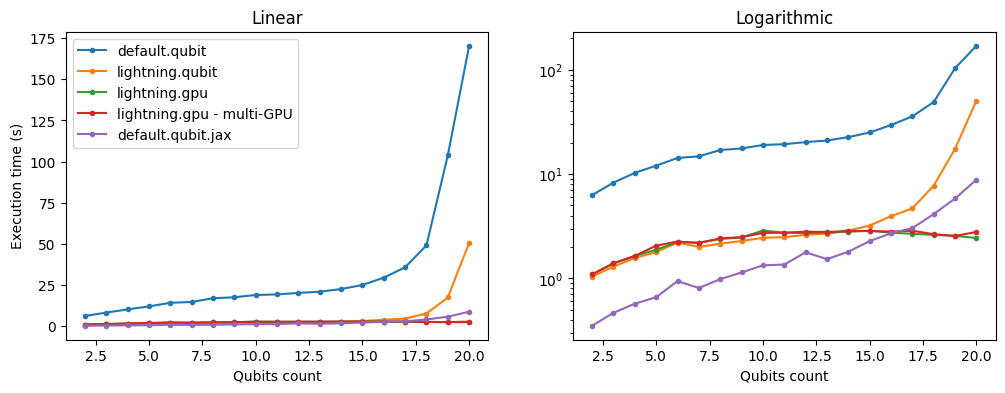

In [21]:
plot_time_per_qubit_counts(execution_times)

As it is seen above - `lightning.gpu` device is the most efficient for filters bigger then 18 qubits.

While `default.qubit.jax` is very useful for smaller filter sizes - which lead to bigger number of filter applications and vectorization benefits.

We can also plot Execution times dependence on number of Filter applications.

Here we see that bigger filter again needs less applications - and `lightning.gpu` is faster.

But as filter size decreases - number of filter applications grows - and `default.qubit.jax` becomes more efficient:

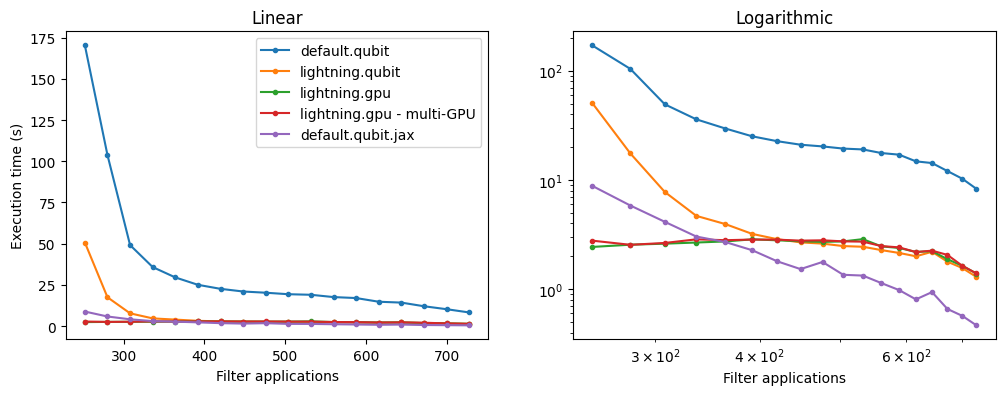

In [23]:
plot_time_per_filter_applications(execution_times)

Situation becomes even more favorable for `default.qubit.jax` with increase in number of filters:

#### 8 Filters

In below example - 8 filters are parallelized over 8 DGX-2 GPU cards - which makes `default.qubit.jax` faster then `lightning.gpu` even for big 20-qubit filters:

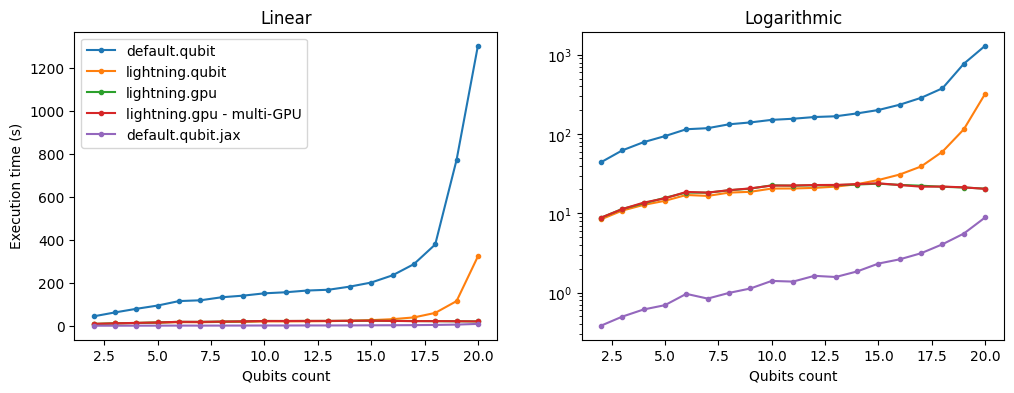

In [29]:
experiments = np.load('experiments/a100_jax_experiments_8_filters.npy', 
                      allow_pickle=True).item()

execution_times = aggregate_execution_times(experiments)

plot_time_per_qubit_counts(execution_times)

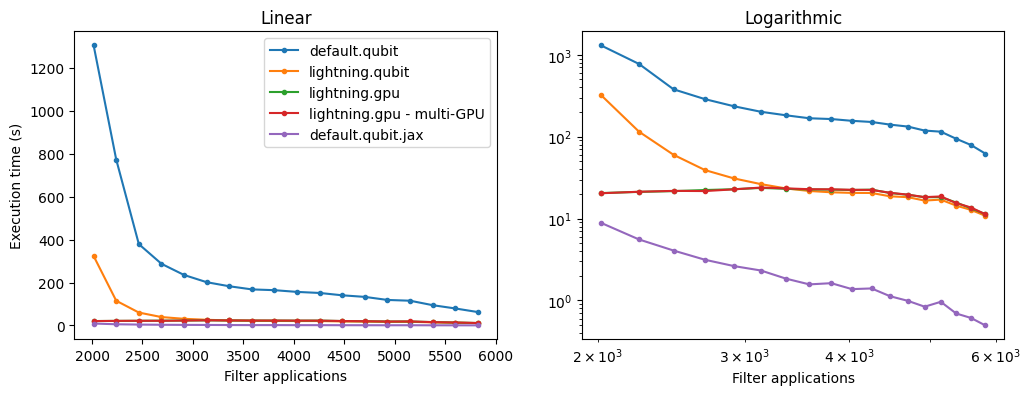

In [30]:
plot_time_per_filter_applications(execution_times)

We made the same comparisons also for NVidia DGX-2 - using 1, 8 and 16 parallel filters.

All experiments data have been uploaded to [`experiments`](experiments/) folder)

### Approach 3 - AWS Braket

AWS Braket provides access to variety of real Quantum Backends, as well as Local Simulators and Cloud-based Managed Simulators.

In scope of Parallel Quanvolution - it is interesting to call mentioned Backends and Simulators for parallel calculation of Filter Quantum Circuits.

In order to do so - we could use default Python Multiprocessing - but then we would have to handle multiple (even 100s and 1000s) of processes running, joining and terminating.

Another experimental option would be Dask.

But since we already have nicely setup JAX framework - let's use it!)

#### Simulators

First, we can use local `braket.local.qubit` Simulator - which is free of charge:

In [32]:
parameters = create_parameters(qml_device_types=["braket.local.qubit"],
                               image_width=28,
                               image_height=28,
                               min_filter_width=2,
                               min_filter_height=2)

experiments = prepare_experiments(parameters)

run_experiments(experiments) 

Experiments count: 1
Experiment: 1/1
Device: braket.local.qubit
Qubits per filter: 4
Filter repetitions: 729
Filter applications: 729
Execution time: 9.60 seconds



Next step is SV1 - AWS Braket Cloud-based Managed state-vector simulator.

Price of 1 second of simulator time is 0.00375 USD - while minimal billed duration per run is 3 seconds.

Let's import cost Tracker - to check overall price of AWS Braket tasks:

In [33]:
TRACK_AWS_BRAKET_COST = True

if TRACK_AWS_BRAKET_COST:    
    from braket.tracking import Tracker

In [36]:
parameters = create_parameters(qml_device_types=["braket.aws.qubit"],
                               image_width=28,
                               image_height=1,
                               min_filter_width=28,
                               min_filter_height=1)

experiments = prepare_experiments(parameters)

run_experiments(experiments) 

Experiments count: 1
Experiment: 1/1
Device: braket.aws.qubit
Qubits per filter: 28
Filter repetitions: 1
Filter applications: 1
Execution time: 15.84 seconds

AWS Braket Tasks Statistics:
ARN: arn:aws:braket:::device/quantum-simulator/amazon/sv1
Tasks: {'COMPLETED': 1}
Execution duration: 0:00:07.166000
Billed duration:    0:00:07.166000
AWS Braket Simulator Cost: 0.0090 USD


As we can see - calculation of big 28-qubit Filter Circuit took only 16 seconds of wall time.

Time of simulation itself is 7 seconds - while the rest is overhead for API call to AWS Braket and queuing.

At the same time - running 28-qubit Filter Circuit on the fastest `lightning.gpu` local simulator device would take around 12 seconds.

#### 8 Filters are back

Running single circuits is interesting - but on practice of Quanvolution we need to deal with numerous repetitions of multiple filters.

Let us run AWS Braket SV1 in parallel for 8 Quanvolution filters:

In [38]:
parameters = create_parameters(qml_device_types=["braket.aws.qubit"],
                               image_width=28,
                               image_height=1,
                               min_filter_width=28,
                               min_filter_height=1,
                               min_filters_count=8,
                               max_filters_count=8)

experiments = prepare_experiments(parameters)

run_experiments(experiments) 

Experiments count: 1
Experiment: 1/1
Device: braket.aws.qubit
Qubits per filter: 28
Filter repetitions: 1
Filter applications: 8
Execution time: 29.82 seconds

AWS Braket Tasks Statistics:
ARN: arn:aws:braket:::device/quantum-simulator/amazon/sv1
Tasks: {'COMPLETED': 8}
Execution duration: 0:01:01.203000
Billed duration:    0:01:01.203000
AWS Braket Simulator Cost: 0.0765 USD


If we check AWS Braket Task queue - we can see all 8 Filter Circuit calculations running in parallel:

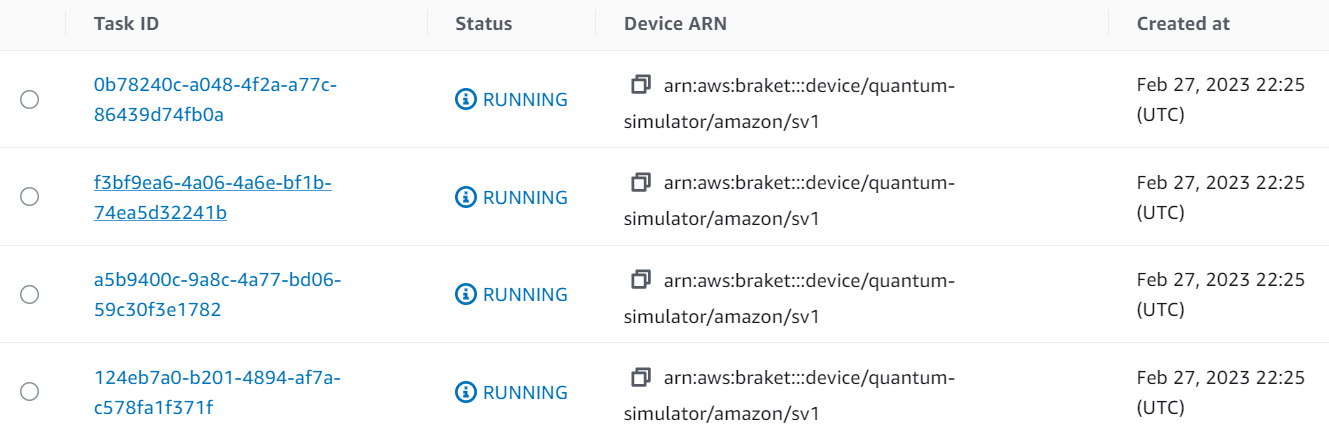

### Conclusions

We have tried 3 approaches for Parallel Quanvolution:

<br>

**1) Multi-GPU on NVidia DGX with `lightning.gpu`**

Pennylane Lightning GPU device is using NVidia cuQuantum SDK and is very efficient for larger circuits.

<br>

**2) JAX parallel with `default.qubit.jax`**

JAX brings vectorization and JIT optimization features - especially useful for large amounts of smaller quantum circuits - like Quanvolution filter circuit.

<br>

**3) JAX parallel with AWS Braket SV1 with `braket.aws.qubit`**

On top of above mentioned JAX features - cloud-based managed Simulator is very productive and allows excellent scaling.

### Further Steps

#### NVidia

For DGX - we used our Quantum Simulator stack based on cuQuantum Appliance.

But it would be very interesting to try new QODA platform - pre-release access to which is kindly provided in scope of QHack!

#### JAX

Calls to other local and remote Quantum devices and Simulators can be easily made from existing implementation of Quanvolution parallelized with JAX.

It would be also definitely interesting to try Catalyst framework - demonstrated on QHack by Josh Izaac - which expands JAX compilation abilities up to Pennylane quantum circuits!

#### AWS

Current solution uses JAX Pmap to parallelize over distinct Quanvolution filters - for example, we had 8 filters with distinct trainable weights quanvolving through MNIST image.

This was initially done to utilize all NVidia DGX GPUs in parallel.

At the same time - another way would be to run each filter *application* in parallel - so that 100s and 1000s of Filter Circuit calls are sent to Simulator and processed simultaneously.

From previous example - applying 8 filters of 10 qubits over one 28*28 MNIST image requires 4256 applications.

Additional batching can be done to fit into selected Simulator usage quotas)

### Code Explanation

Out improvised Parallel Quanvolution framework uses only 3 interface functions:
    
* `create_parameters`
* `prepare_experiments`
* `run_experiments`

But under the hood - notebook [`functions.ipynb`](functions.ipynb) contains below sections:

* Parameters Processing
* Image Processing
* Quantum
* Parallelization
* Experiments
* Visualization

Let us explain the code:

**Parameters Processing**

`create_parameters` function uses input values:

* QML Device Types
* Image width and height
* Filter width and height
* Filters counts
* Stride width and height
* Trainable layers count of Filter Circuit
* Unique filter repetitions

Input values are turned into ranges of secondary parameters - which will be further used for creating experiments.

**Image Processing**

`load_one_MNIST_image` - loads our example MNIST image from Keras.

`parse_image` - calculates numbers of horizontal and vertical filter repetitions - from image, filter and stride sizes.

`get_pixel_values` - splits given image into pixel arrays to be used for filter applications.




**Parallelization**

`quanvolve_vmap` - vectorization map to apply filter_circuit to arrays of pixels and trainable parameters.

`quanvolve_pmap` - parallelization map for the same)

`quanvolve_no_vmap`, `quanvolve_no_pmap` - usual loops to use for backends not compatible with JAX

**Experiments**

`prepare_experiments` - enriches image, filter and device parameters with QML interface values, vectorize and parallelize flags.

`run_experiment` - runs one experiment on selected device considering above parameters.

`run_experiments` - iterates over prepared experiments, printouts results.

**Visualization**

`aggregate_execution_times` - aggregates circuit execution times per device type.

`plot_time_per_qubit_counts` - plots execution times per Filter Circuit qubits count.

`plot_time_per_filter_applications` - plots execution times per Filter Circuit applications.

`draw_filter_circuit` - plots Quanvolution Filter Circuit.

`plot_image` - plots MNIST image.

**Quantum**

`filter_circuit` specifies structure of Quantum Filter circuit:

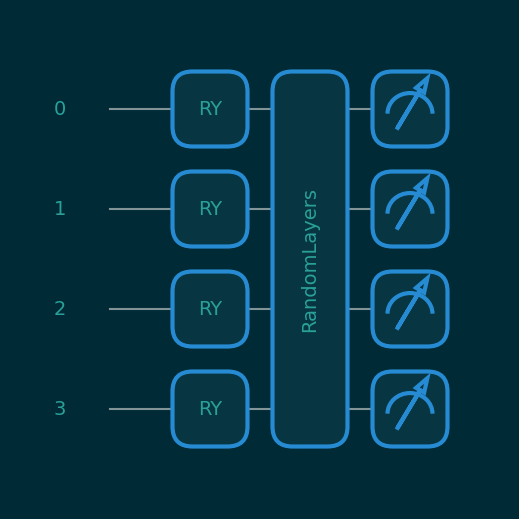

In [39]:
draw_filter_circuit(filter_circuit, wires_count=4)